In [13]:
# Import necessary libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.decomposition import PCA
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.decomposition import TruncatedSVD
# KNN with reduced dimensions
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score



In [1]:
import pandas as pd

# Load the full dataset
df_full = pd.read_parquet('modeling_dataset_v.0.parquet')

# Display the first few rows of the dataset
print(df_full.head())


          fare_amount  trip_duration  trip_distance  total_amount  tip_amount  \
19276873         19.1      20.366667           2.32         30.72        5.12   
25505385         17.7      18.933333           1.90         25.20        3.50   
23056552          8.6       8.950000           1.10         12.10        2.00   
22171336         10.0       8.966667           1.00         16.00        2.00   
25241061          7.9       5.783333           1.07         14.88        2.98   

          speed_mph  JFK_LGA_Pickup_Fee  General_Airport_Fee  log_fare_amount  \
19276873   6.834697                 0.0                  0.0         3.000720   
25505385   6.021127                 0.0                  0.0         2.928524   
23056552   7.374302                 0.0                  0.0         2.261763   
22171336   6.691450                 0.0                  0.0         2.397895   
25241061  11.100865                 0.0                  0.0         2.186051   

          log_trip_duratio

In [3]:
len(df_full)

2805668

In [4]:
from sklearn.model_selection import train_test_split

# Create a combined column for stratification
df_full['stratify_col'] = (df_full['pickup_season'].astype(str) + '_' +
                           df_full['pickup_time_of_day'].astype(str) + '_' +
                           df_full['pickup_day_type'].astype(str) + '_' +
                           df_full['PUborough'].astype(str) + '_' +
                           df_full['DOborough'].astype(str))


In [5]:
# Check the distribution of the combined stratification column
stratify_counts = df_full['stratify_col'].value_counts()
print(stratify_counts)


stratify_col
spring_evening_weekday_Manhattan_Manhattan      162096
spring_afternoon_weekday_Manhattan_Manhattan    152673
autumn_evening_weekday_Manhattan_Manhattan      149395
autumn_afternoon_weekday_Manhattan_Manhattan    140089
winter_afternoon_weekday_Manhattan_Manhattan    139463
                                                 ...  
autumn_night_weekend_Unknown_EWR                     1
autumn_afternoon_weekday_EWR_EWR                     1
autumn_evening_weekday_Unknown_EWR                   1
spring_night_weekday_Staten Island_Queens            1
winter_night_weekday_Unknown_EWR                     1
Name: count, Length: 1050, dtype: int64


In [6]:

# Filter out classes with very few samples
min_class_size = 5  # Define a minimum class size
filtered_classes = stratify_counts[stratify_counts >= min_class_size].index
df_filtered = df_full[df_full['stratify_col'].isin(filtered_classes)]


In [7]:

# Perform stratified sampling on the filtered dataset
df_sample, df_test = train_test_split(df_filtered, test_size=0.3, stratify=df_filtered['stratify_col'], random_state=42)


In [8]:

# Drop the stratify column
df_sample = df_sample.drop(columns=['stratify_col'])
df_test = df_test.drop(columns=['stratify_col'])

print("Sampled dataset for testing:")
print(df_test.head())


Sampled dataset for testing:
          fare_amount  trip_duration  trip_distance  total_amount  tip_amount  \
18703554         33.1      25.583333           7.33         39.60        0.00   
27905264         14.9      12.883333           2.51         24.40        3.00   
25147921         14.2      14.583333           1.90         21.84        3.64   
27160600         25.4      22.183333           4.80         30.40        0.00   
9308204          31.7      33.416667           6.40         40.34        4.64   

          speed_mph  JFK_LGA_Pickup_Fee  General_Airport_Fee  log_fare_amount  \
18703554  17.190879                 0.0                  0.0         3.529297   
27905264  11.689521                 0.0                  0.0         2.766319   
25147921   7.817143                 0.0                  0.0         2.721295   
27160600  12.982720                 0.0                  0.0         3.273364   
9308204   11.491272                 0.0                  0.0         3.487375  

In [9]:
len(df_test)

841541

In [14]:


# Select features to include in the model
features_test = df_test[['trip_distance', 'trip_duration', 'tip_amount', 'PCA1', 'PCA2',
                         'is_holiday', 'pickup_time_of_day', 'pickup_season', 'passenger_count_category',
                         'pickup_day_type', 'PUzone', 'PUborough', 'DOzone', 'DOborough']]

target_test = df_test['fare_amount']

# Load the encoder and polynomial features transformer
encoder = joblib.load('encoder.pkl')
poly = joblib.load('poly.pkl')

# Encode categorical features using the previously fitted encoder
X_test_encoded = encoder.transform(features_test)

# Apply polynomial transformations using the previously fitted polynomial features transformer
X_test_poly = poly.transform(X_test_encoded)



In [15]:
# Load the trained model
xgb_model = joblib.load('xgb_model_polynomial.pkl')

# Use the trained model to predict fares
predicted_fares = xgb_model.predict(X_test_poly)

# Add predicted fares to the dataset
df_test['predicted_fare'] = predicted_fares

# Display the test dataset with predictions
print(df_test.head())




          fare_amount  trip_duration  trip_distance  total_amount  tip_amount  \
18703554         33.1      25.583333           7.33         39.60        0.00   
27905264         14.9      12.883333           2.51         24.40        3.00   
25147921         14.2      14.583333           1.90         21.84        3.64   
27160600         25.4      22.183333           4.80         30.40        0.00   
9308204          31.7      33.416667           6.40         40.34        4.64   

          speed_mph  JFK_LGA_Pickup_Fee  General_Airport_Fee  log_fare_amount  \
18703554  17.190879                 0.0                  0.0         3.529297   
27905264  11.689521                 0.0                  0.0         2.766319   
25147921   7.817143                 0.0                  0.0         2.721295   
27160600  12.982720                 0.0                  0.0         3.273364   
9308204   11.491272                 0.0                  0.0         3.487375   

          log_trip_duratio

Test MAE: 0.6560960014892077
Test R²: 0.9943630866429524


/var/folders/4d/8tkcz58x0md0_v7fj12j6ht80000gn/T/ipykernel_5893/3801113545.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([df_test['fare_amount'].min(), df_test['fare_amount'].max()],


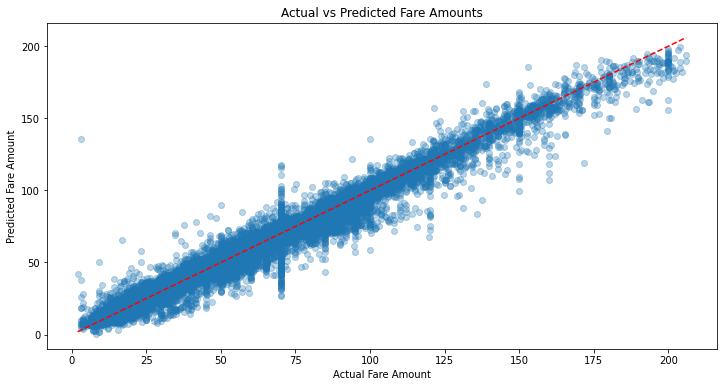

In [16]:
# Evaluate the model on the test set
mae_test = mean_absolute_error(df_test['fare_amount'], df_test['predicted_fare'])
r2_test = r2_score(df_test['fare_amount'], df_test['predicted_fare'])

print("Test MAE:", mae_test)
print("Test R²:", r2_test)

# Scatter plot for predictions vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(df_test['fare_amount'], df_test['predicted_fare'], alpha=0.3)
plt.plot([df_test['fare_amount'].min(), df_test['fare_amount'].max()],
         [df_test['fare_amount'].min(), df_test['fare_amount'].max()], '--k', color='red')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.title('Actual vs Predicted Fare Amounts')
plt.show()

### Analysis of Model Testing Results

### Interpretation and Insights

1. **High Accuracy**:
   - The model demonstrates high accuracy in predicting taxi fares with low MAE and high R² values. This indicates that the model is well-calibrated and effectively captures the relationship between the input features and the fare amount.

2. **Robustness**:
   - The stratified sampling ensures that the model is tested on a representative subset of the data, covering different times of day, seasons, and other relevant features. The model’s strong performance across this diverse dataset suggests robustness and generalizability.

3. **Feature Importance**:
   - While feature importance was not directly analyzed in the provided results, the model’s performance implies that the key features (trip distance, trip duration, time of day, etc.) significantly contribute to accurate fare predictions. Further analysis of feature importance can help identify the most influential features.

### Next Steps for Deployment

Given the strong performance of the model, you can proceed with deploying it for real-world use. Here’s a summary of the steps:

1. **Model Validation and Tuning**:
   - Although the model performs well, consider further validation using cross-validation and potential hyperparameter tuning to ensure optimal performance.

2. **Model Deployment**:
   - Deploy the model using a web service or API, such as Flask or FastAPI. This allows users to make fare predictions in real-time by sending input data to the API.

3. **Monitoring and Maintenance**:
   - Regularly monitor the model’s performance in production. Implement logging to track predictions and identify any issues.
   - Periodically retrain the model with new data to maintain accuracy and adapt to any changes in the underlying patterns.

4. **Documentation and Communication**:
   - Document the entire modeling process, including data preprocessing, model training, testing, and deployment.
   - Communicate the model’s performance, key insights, and limitations to stakeholders.

### Example Code for API Deployment

Here’s an example of how you can deploy the model using Flask:

```python
from flask import Flask, request, jsonify
import joblib
import numpy as np

# Load the model and preprocessing objects
model = joblib.load('xgb_model_polynomial.pkl')
encoder = joblib.load('encoder.pkl')
poly = joblib.load('poly.pkl')

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    
    # Extract features from the request
    features = np.array([[
        data['trip_distance'], data['trip_duration'], data['tip_amount'], 
        data['PCA1'], data['PCA2'], data['is_holiday'], data['pickup_time_of_day'], 
        data['pickup_season'], data['passenger_count_category'], data['pickup_day_type'], 
        data['PUzone'], data['PUborough'], data['DOzone'], data['DOborough']
    ]])
    
    # Preprocess the features
    features_encoded = encoder.transform(features)
    features_poly = poly.transform(features_encoded)
    
    # Make prediction
    prediction = model.predict(features_poly)
    
    # Return the prediction as JSON
    return jsonify({'predicted_fare': prediction[0]})

if __name__ == '__main__':
    app.run(debug=True)
```

### Conclusion

The testing results indicate that the model performs exceptionally well in predicting taxi fares, with high accuracy and robustness. Proceed with deployment while ensuring continuous monitoring and maintenance to sustain performance in real-world applications. This will allow you to leverage the model’s capabilities for practical use in predicting taxi fares and potentially informing fare regulation strategies in Tbilisi.